In [1]:
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

sns.set_theme(style="whitegrid")

In [30]:
# EIP4844 configuration
MAX_BLOB_GAS_PER_BLOCK = 786432
TARGET_BLOB_GAS_PER_BLOCK = 393216
MIN_BASE_FEE_PER_BLOB_GAS = 1
BLOB_BASE_FEE_UPDATE_FRACTION = 3338477
GAS_PER_BLOB = 2**17

# simuplation configuration
TIMESTEMPS = 5 * 60 * 24 * 2
RUNS = 200

In [3]:
# EIP-4844 Pricing Formula

def fake_exponential(factor: int, numerator: int, denominator: int) -> int:
    i = 1
    output = 0
    numerator_accum = factor * denominator
    while numerator_accum > 0:
        output += numerator_accum
        numerator_accum = (numerator_accum * numerator) // (denominator * i)
        i += 1
    return output // denominator

def fake_exponential_bn(factor: int, numerator: int, denominator: int) -> int:
    _factor = np.int64(factor)
    _numerator = np.int64(numerator)
    _denominator = np.int64(denominator)
    i = np.int64(1)
    _output = np.int64(0)
    _numerator_accum = _factor * _denominator
    while _numerator_accum > 0:
        _output = np.add(_output, _numerator_accum, dtype=object)
        _numerator_accum = np.floor_divide(np.multiply(_numerator_accum, _numerator, dtype=object), np.multiply(_denominator, i, dtype=object), dtype=object)
        i += 1
    return np.floor_divide(_output, _denominator, dtype=object)

def calc_excess_blob_gas(target_blob_gas_per_block: int, parent_excess_blob_gas: int, parent_blob_gas_used: int) -> int:
    if parent_excess_blob_gas + parent_blob_gas_used < target_blob_gas_per_block:
        return 0
    else:
        return parent_excess_blob_gas + parent_blob_gas_used - target_blob_gas_per_block

def get_base_fee_per_blob_gas(min_base_fee_per_blob_gas: int, excess_blob_gas: int, blob_base_fee_update_fraction: int) -> int:
    return fake_exponential(
        min_base_fee_per_blob_gas,
        excess_blob_gas,
        blob_base_fee_update_fraction
    )

In [4]:
# EIP-4844 Blob Fee Market Model

def policy_resource_fee(params, substep, state_history, previous_state):
    target_blob_gas_per_block = params['target_blob_gas_per_block']

    parent_blob_gas_used = previous_state['blob_gas_used']
    parent_excess_blob_gas = previous_state['excess_blob_gas']

    excess_blob_gas = calc_excess_blob_gas(target_blob_gas_per_block, parent_excess_blob_gas, parent_blob_gas_used)

    return {
        'excess_blob_gas': excess_blob_gas
    }

def policy_resource_usage(params, substep, state_history, previous_state):
    process_blob_gas_used = params['process_blob_gas_used']
    
    run = previous_state['run']
    timestep = previous_state['timestep']

    blob_gas_used = process_blob_gas_used(run, timestep)

    return {
        'blob_gas_used': blob_gas_used
    }

def update_excess_blob_gas(params, substep, state_history, previous_state, policy_input):
    excess_blob_gas = policy_input['excess_blob_gas']
    return ('excess_blob_gas', excess_blob_gas)

def update_blob_gas_used(params, substep, state_history, previous_state, policy_input):
    blob_gas_used = policy_input['blob_gas_used']
    return ('blob_gas_used', blob_gas_used)

initial_state = {
    'blob_gas_used': 0,
    'excess_blob_gas': 0,
}

state_update_blocks = [
    {
        'policies': {
            'resource_fee': policy_resource_fee,
        },
        'variables': {
            'excess_blob_gas': update_excess_blob_gas,
        }
    },
    {
        'policies': {
            'resource_usage': policy_resource_usage,
        },
        'variables': {
            'blob_gas_used': update_blob_gas_used,
        }
    },
]

In [31]:
# Demand Sampling

rng = np.random.default_rng()

def truncated_poisson(lam: int, max_value: int, size: int):
    temp_size = size
    while True:
        temp_size *= 2
        temp = rng.poisson(lam=lam, size=temp_size)
        truncated = temp[temp <= max_value]
        if len(truncated) >= size:
            return truncated[:size]
    
def generate_poisson_demand(lam: int):
    return [truncated_poisson(lam=lam, max_value=6, size=TIMESTEMPS + 1) * GAS_PER_BLOB for run in range(RUNS)]

def generate_uniform_demand():
    return rng.integers(low=0, high=6, size=(RUNS, TIMESTEMPS + 1), endpoint=True) * GAS_PER_BLOB

def generate_bimodal_demand():
    return rng.choice(a=[0, 1, 2, 3, 4, 5, 6], p=[0.5, 0, 0, 0, 0, 0, 0.5], size=(RUNS, TIMESTEMPS + 1)) * GAS_PER_BLOB

def generate_history_demand():
    return rng.choice(a=[0, 1, 2, 3, 4, 5, 6], p=[0.282, 0.11, 0.04, 0.083, 0.087, 0.184, 0.214], size=(RUNS, TIMESTEMPS + 1)) * GAS_PER_BLOB

In [37]:
cases = [
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 1',
        'samples': generate_poisson_demand(1)
    },
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 5',
        'samples': generate_poisson_demand(5)
    },
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 3',
        'samples': generate_poisson_demand(3)
    },
    {
        'name': 'The blob demand follows an uniform distribution',
        'samples': generate_uniform_demand()
    },
    {
        'name': 'The blob demand follows a bimodal distribution',
        'samples': generate_bimodal_demand()
    },
]

In [38]:
def create_simulation(case):
    model = Model(
        initial_state=initial_state,
        state_update_blocks=state_update_blocks,
        params={
            'target_blob_gas_per_block': [TARGET_BLOB_GAS_PER_BLOCK],
            'process_blob_gas_used': [lambda run, timestep: case['samples'][run - 1][timestep]],
        },
    )
    simulation = Simulation(
        model=model,
        timesteps=TIMESTEMPS,
        runs=RUNS
    )
    return simulation

simulations = list(map(create_simulation, cases))
experiment = Experiment(simulations=simulations)
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result = experiment.run()

In [39]:
df = pd.DataFrame(result)
df

,blob_gas_used,excess_blob_gas,simulation,subset,run,substep,timestep
0,0,0,0,0,1,0,0
1,393216,0,0,0,1,2,1
2,0,0,0,0,1,2,2
3,262144,0,0,0,1,2,3
4,393216,0,0,0,1,2,4
...,...,...,...,...,...,...,...
14400995,786432,41287680,4,0,200,2,14396
14400996,786432,41680896,4,0,200,2,14397
14400997,0,42074112,4,0,200,2,14398
14400998,0,41680896,4,0,200,2,14399


In [40]:
df_excess_blob_gas_stats = df.groupby(['simulation', 'timestep'])['excess_blob_gas'].describe()
df_excess_blob_gas_stats["base_fee_per_blob_gas"] = df_excess_blob_gas_stats["mean"].apply(lambda value: get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, value, BLOB_BASE_FEE_UPDATE_FRACTION))
df_excess_blob_gas_stats


count         mean           std  min         25%  \
simulation timestep                                                      
0          0         200.0         0.00  0.000000e+00  0.0         0.0   
           1         200.0         0.00  0.000000e+00  0.0         0.0   
           2         200.0      1966.08  1.597210e+04  0.0         0.0   
           3         200.0      3932.16  3.194421e+04  0.0         0.0   
           4         200.0      3932.16  2.598285e+04  0.0         0.0   
...                    ...          ...           ...  ...         ...   
4          14396     200.0  36242718.72  2.956613e+07  0.0  11698176.0   
           14397     200.0  36228956.16  2.950990e+07  0.0  11796480.0   
           14398     200.0  36250583.04  2.956180e+07  0.0  12091392.0   
           14399     200.0  36191600.64  2.953623e+07  0.0  12386304.0   
           14400     200.0  36264345.60  2.951071e+07  0.0  12091392.0   

                            50%         75%          max  \
simulation timestep                                        
0          0                0.0         0.0          0.0   
           1                0.0         0.0          0.0   
           2                0.0         0.0     131072.0   
           3                0.0         0.0     393216.0   
           4                0.0         0.0     262144.0   
...                         ...         ...          ...   
4          14396     30081024.0  51609600.0  141164544.0   
           14397     30081024.0  51216384.0  141557760.0   
           14398     30081024.0  51019776.0  141950976.0   
           14399     30081024.0  51216384.0  142344192.0   
           14400     30081024.0  51609600.0  141950976.0   

                     base_fee_per_blob_gas  
simulation timestep                         
0          0                           1.0  
           1                           1.0  
           2                           1.0  
           3                           1.0  
           4                           1.0  
...                                    ...  
4          14396                   51847.0  
           14397                   51634.0  
           14398                   51969.0  
           14399                   51059.0  
           14400                   52184.0  

[72005 rows x 9 columns]

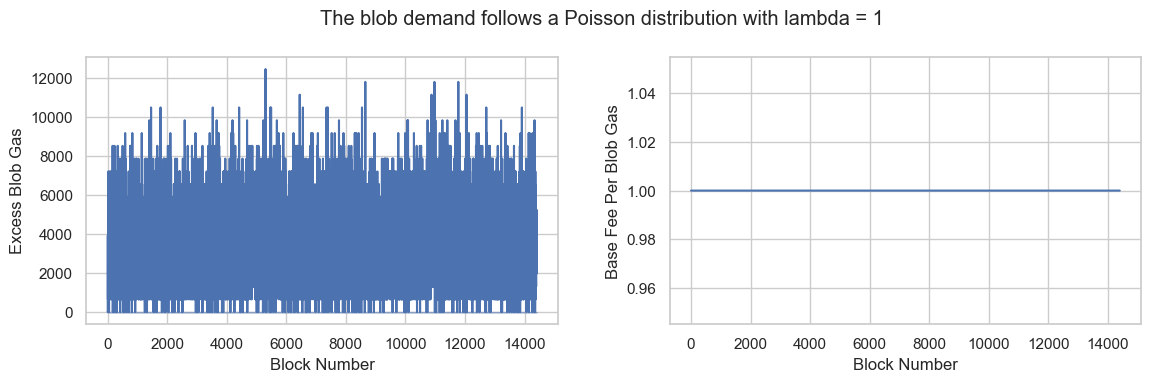

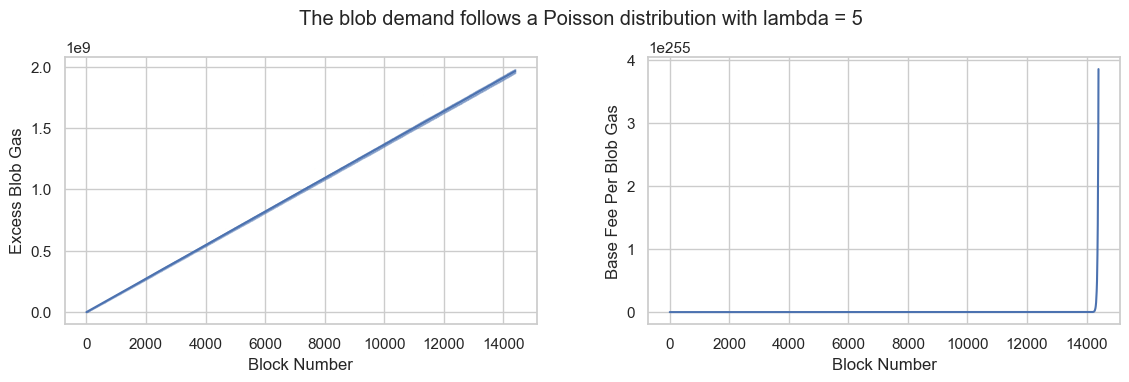

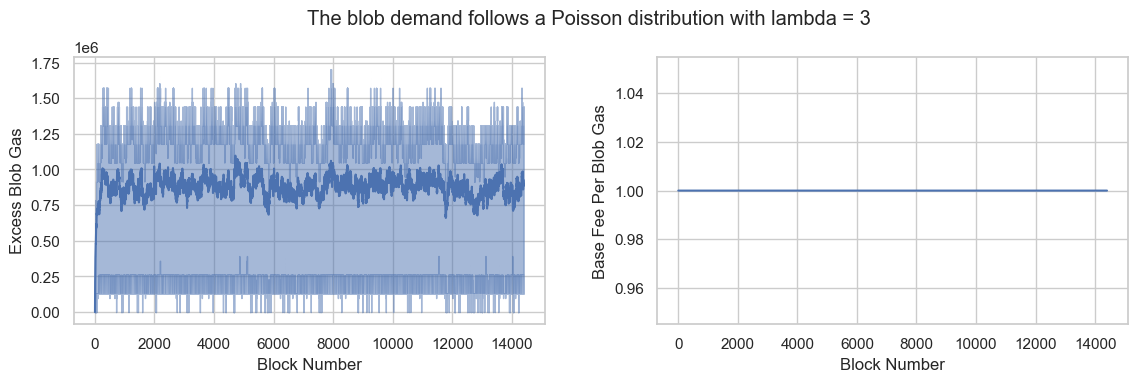

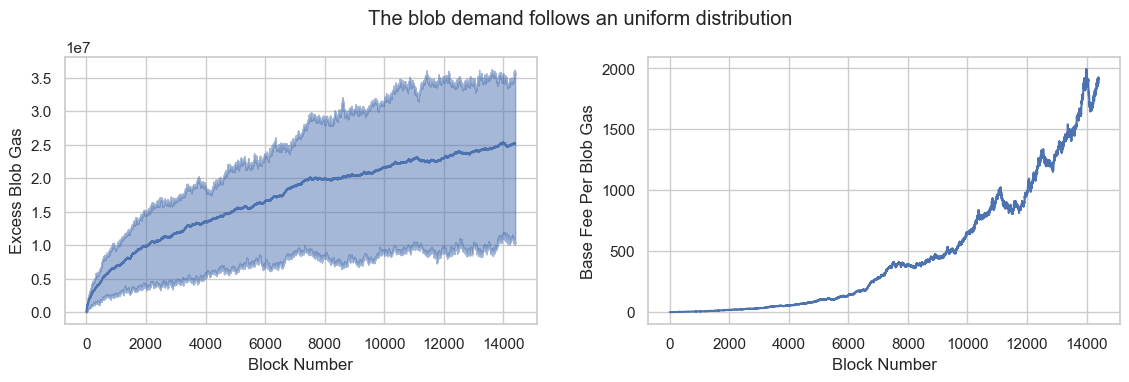

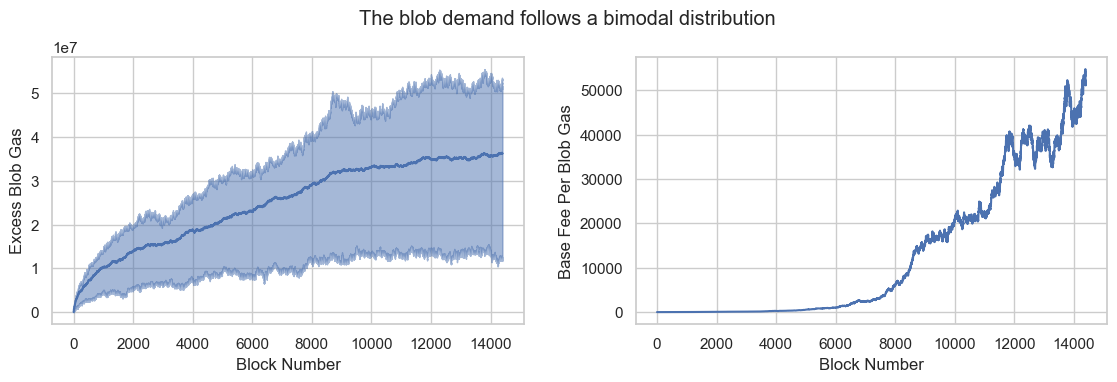

In [41]:
for index, case in enumerate(cases):
    excess_blob_gas = df_excess_blob_gas_stats.loc[index]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout(pad=3, w_pad=4, h_pad=3)
    fig.suptitle(case['name'])

    ax1.plot(excess_blob_gas.index, excess_blob_gas['mean'].values, label='Mean')
    ax1.fill_between(excess_blob_gas.index, excess_blob_gas['25%'].values, excess_blob_gas['75%'].values, color='b', alpha=0.5)
    ax1.set_xlabel('Block Number')
    ax1.set_ylabel('Excess Blob Gas')

    ax2.plot(excess_blob_gas.index, excess_blob_gas['base_fee_per_blob_gas'].values, label='Mean')
    ax2.set_xlabel('Block Number')
    ax2.set_ylabel('Base Fee Per Blob Gas')

    fig.savefig(f'img/eip4844-t{TIMESTEMPS}-r{RUNS}-c{index + 1}.png')


## Find the stable condition of the blob demand

In [13]:
demand_values = np.arange(3.1, 3.2, 0.01).round(2)

def create_simulation(demand_value: int):
    samples = generate_poisson_demand(demand_value)
    model = Model(
        initial_state=initial_state,
        state_update_blocks=state_update_blocks,
        params={
            'target_blob_gas_per_block': [TARGET_BLOB_GAS_PER_BLOCK],
            'process_blob_gas_used': [lambda run, timestep: samples[run - 1][timestep]],
        },
    )
    simulation = Simulation(
        model=model,
        timesteps=TIMESTEMPS,
        runs=RUNS
    )
    return simulation

simulations_sc = list(map(create_simulation, demand_values))
experiment_sc = Experiment(simulations=simulations_sc)
experiment_sc.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result_sc = experiment_sc.run()

In [14]:
df_sc = pd.DataFrame(result_sc)
df_sc

,blob_gas_used,excess_blob_gas,simulation,subset,run,substep,timestep
0,0,0,0,0,1,0,0
1,131072,0,0,0,1,2,1
2,655360,0,0,0,1,2,2
3,393216,262144,0,0,1,2,3
4,393216,262144,0,0,1,2,4
...,...,...,...,...,...,...,...
19800545,262144,46137344,10,0,50,2,35996
19800546,524288,46006272,10,0,50,2,35997
19800547,131072,46137344,10,0,50,2,35998
19800548,786432,45875200,10,0,50,2,35999


In [15]:
df_stats_sc = df_sc.groupby(['simulation', 'timestep'])['excess_blob_gas'].describe()
df_stats_sc['base_fee_per_blob_gas'] = df_stats_sc['mean'].apply(lambda value: get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, value, BLOB_BASE_FEE_UPDATE_FRACTION))
df_stats_sc

count         mean           std        min        25%  \
simulation timestep                                                           
0          0          50.0         0.00  0.000000e+00        0.0        0.0   
           1          50.0         0.00  0.000000e+00        0.0        0.0   
           2          50.0    120586.24  1.563025e+05        0.0        0.0   
           3          50.0    159907.84  1.986747e+05        0.0        0.0   
           4          50.0    212336.64  2.468379e+05        0.0        0.0   
...                    ...          ...           ...        ...        ...   
10         35996      50.0  24287641.60  2.287159e+07   524288.0  6193152.0   
           35997      50.0  24264048.64  2.283769e+07   655360.0  6127616.0   
           35998      50.0  24256184.32  2.289213e+07   786432.0  6062080.0   
           35999      50.0  24266670.08  2.285846e+07   786432.0  5963776.0   
           36000      50.0  24253562.88  2.287597e+07  1048576.0  5898240.0   

                            50%         75%          max  \
simulation timestep                                        
0          0                0.0         0.0          0.0   
           1                0.0         0.0          0.0   
           2                0.0    262144.0     393216.0   
           3           131072.0    262144.0     786432.0   
           4           131072.0    360448.0     917504.0   
...                         ...         ...          ...   
10         35996     18087936.0  38371328.0  123207680.0   
           35997     18087936.0  38371328.0  123076608.0   
           35998     17956864.0  38371328.0  123469824.0   
           35999     18022400.0  38600704.0  123207680.0   
           36000     18022400.0  38371328.0  123600896.0   

                     base_fee_per_blob_gas  
simulation timestep                         
0          0                           1.0  
           1                           1.0  
           2                           1.0  
           3                           1.0  
           4                           1.0  
...                                    ...  
10         35996                    1443.0  
           35997                    1433.0  
           35998                    1430.0  
           35999                    1434.0  
           36000                    1429.0  

[396011 rows x 9 columns]

In [16]:
stable_demand_range = [None, None]

for index, demand_value in enumerate(demand_values):
    stats = df_stats_sc.loc[index]
    tail_from = TIMESTEMPS - 7200
    tail_stats = stats['mean'][tail_from:]
    trend = tail_stats.diff().mean()
    if stable_demand_range[0] is None and tail_stats.mean() > GAS_PER_BLOB * 18:
        stable_demand_range[0] = demand_value
    if trend < 1000:
        stable_demand_range[1] = demand_value

stable_demand_range

[3.13, 3.2]

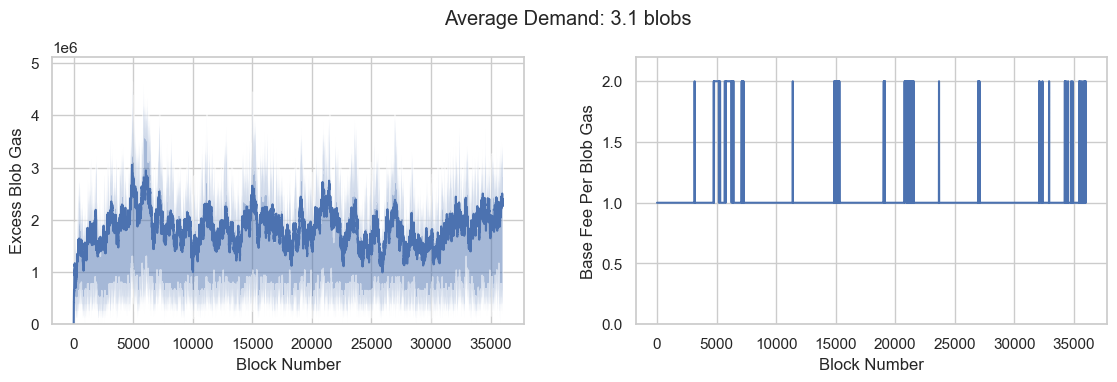

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=3, w_pad=4, h_pad=3)

ax1.set_xlabel('Block Number')
ax1.set_ylabel('Excess Blob Gas')
line1, = ax1.plot(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1))
area1 = ax1.fill_between(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1), alpha=0.5)

ax2.set_xlabel('Block Number')
ax2.set_ylabel('Base Fee Per Blob Gas')
line2, = ax2.plot(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1))

def updateFrame(frame: int):
    stats = df_stats_sc.loc[frame]
    fig.suptitle(f'Average Demand: {demand_values[frame]} blobs')
    ax1.set_ylim(top=stats['75%'].values.max() * 1.1, bottom=0)
    line1.set_ydata(stats['mean'].values)
    area1.set_data(stats.index, stats['25%'].values, stats['75%'].values)
    ax2.set_ylim(top=np.max([stats['base_fee_per_blob_gas'].max() * 1.1, 2]), bottom=0)
    line2.set_ydata(stats['base_fee_per_blob_gas'].values)

ani = FuncAnimation(fig, updateFrame, frames=range(len(demand_values)), interval=1000)
HTML(ani.to_jshtml())



In [21]:
ani.save('img/eip4844-effective-demand.gif', writer='imagemagick', fps=1)

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
s4 = rng.integers(low=0, high=6, size=(RUNS, TIMESTEMPS + 1), endpoint=True)
s4.var()

In [ ]:
s5 = rng.choice(a=[0, 1, 2, 3, 4, 5, 6], p=[0.5, 0, 0, 0, 0, 0, 0.5], size=(RUNS, TIMESTEMPS + 1))
s5.var()

In [27]:
16000 * 12 / 60 / 60 / 24

2.2222222222222223

unifrom demand
    initial blob gas: GAS_PER_BLOB * 550 -> blob base fee: 2e9 (flat)

realistic demand
    initial blob gas: GAS_PER_BLOB * 250 -> blob base fee: 1e4 (flat)